# Step1
import thư viện

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



# Step2
Tải dữ liệu

In [2]:
payloads = pd.read_csv("dataset/payloads.csv",index_col='index')
display(payloads.head(20))

,payload,is_malicious,injection_type
index,,,
0,Yorick,0.0,LEGAL
1,audrean,0.0,LEGAL
2,Donet+Acst,0.0,LEGAL
3,Nicodemo,0.0,LEGAL
4,Waters,0.0,LEGAL
5,typographical,0.0,LEGAL
6,retinal,0.0,LEGAL
7,bringers,0.0,LEGAL
8,presupposing,0.0,LEGAL


# Step3A - Tạo custom features  
Tạo những đặc trưng cho bài toán, bao gồm:
 - Độ dài dữ liệu
 - Số lượng dấu câu trong dữ liệu
 - Byte nhỏ nhất trong dữ liệu
 - Trung bình byte trong dữ liệu
 - Độ lệch chuẩn byte trong dữ liệu
 - Số lượng từ khóa SQL trong dữ liệu
 - Số lượng từ khóa JS trong dữ liệu

In [3]:
# Tạo biểu đồ phân phối của các đặc trưng
def plot_feature_distribution(features):
    print('Properties of feature: ' + features.name)
    print(features.describe())
    f, a = plt.subplots(1, figsize=(10, 6))
    a.hist(features, bins=features.max()-features.min()+1)
    a.set_xlabel('value')
    a.set_ylabel('fraction')
    plt.show()

Tạo đặc trưng Độ dài dữ liệu

,payload,is_malicious,injection_type,length
index,,,,
0,Yorick,0.0,LEGAL,6
1,audrean,0.0,LEGAL,7
2,Donet+Acst,0.0,LEGAL,10
3,Nicodemo,0.0,LEGAL,8
4,Waters,0.0,LEGAL,6


Properties of feature: length
count    102146.000000
mean         12.068852
std          19.347704
min           1.000000
25%           6.000000
50%           8.000000
75%          12.000000
max         785.000000
Name: length, dtype: float64


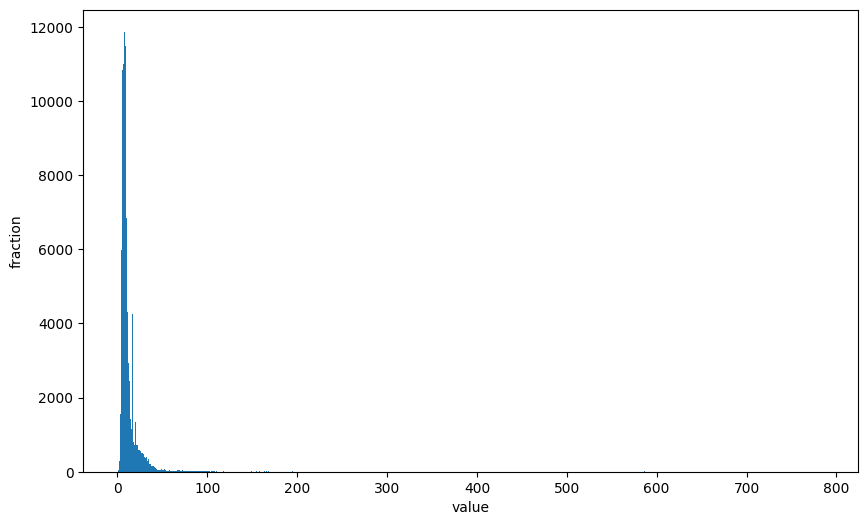

In [4]:
def create_feature_length(payloads):

    payloads['length'] = [len(str(s)) for s in payloads['payload']]
    return payloads

payloads = create_feature_length(payloads)
display(payloads.head())

plot_feature_distribution(payloads['length'])


Tạo đặc trưng Số dấu câu trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation
index,,,,,
0,Yorick,0.0,LEGAL,6,0
1,audrean,0.0,LEGAL,7,0
2,Donet+Acst,0.0,LEGAL,10,1
3,Nicodemo,0.0,LEGAL,8,0
4,Waters,0.0,LEGAL,6,0


Properties of feature: punctuation
count    102146.000000
mean          0.858732
std           3.224165
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         120.000000
Name: punctuation, dtype: float64


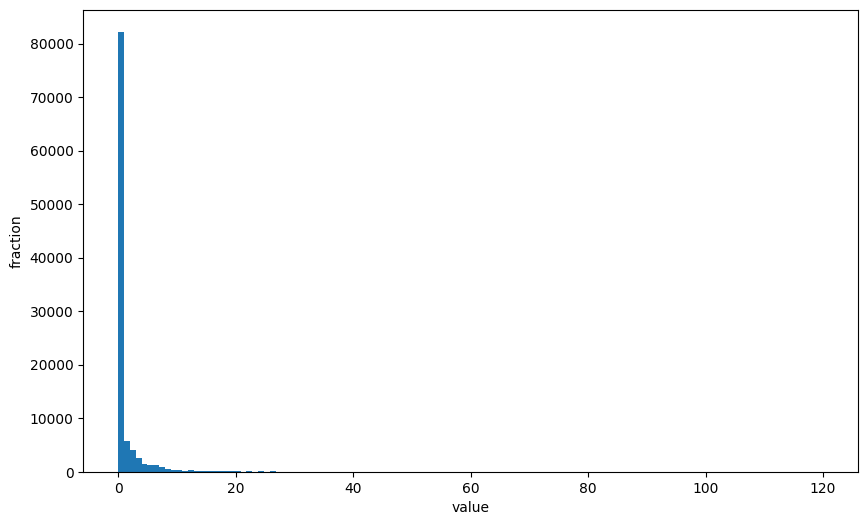

In [5]:
def create_feature_punctuation_characters(payloads):

    payloads['punctuation'] = [ len([1 for letter in str(s) if letter in string.punctuation]) for s in payloads['payload']]
    return payloads
    
create_feature_punctuation_characters(payloads)
display(payloads.head())
    
plot_feature_distribution(payloads['punctuation'])

Tạo đặc trưng Byte nhỏ nhất trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte
index,,,,,,
0,Yorick,0.0,LEGAL,6,0,89
1,audrean,0.0,LEGAL,7,0,97
2,Donet+Acst,0.0,LEGAL,10,1,43
3,Nicodemo,0.0,LEGAL,8,0,78
4,Waters,0.0,LEGAL,6,0,87


Properties of feature: min-byte
count    102146.000000
mean         74.216093
std          25.287816
min          32.000000
25%          48.000000
50%          80.000000
75%          97.000000
max         125.000000
Name: min-byte, dtype: float64


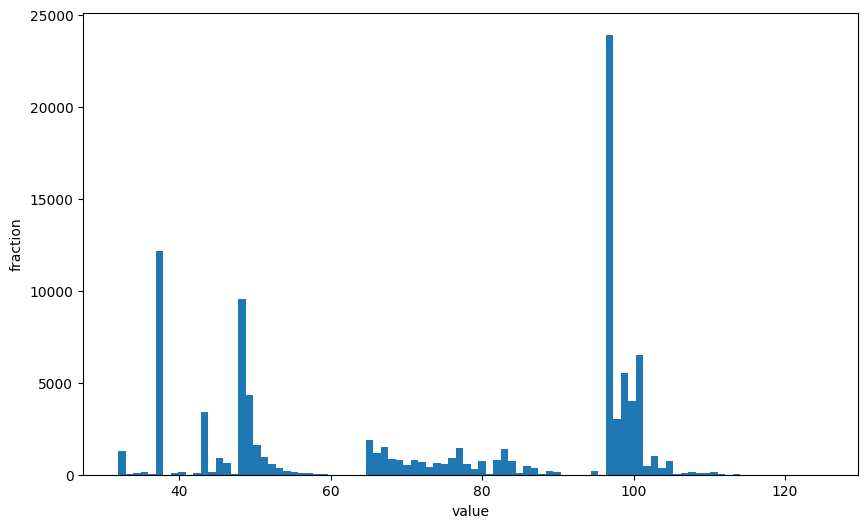

In [6]:
def create_feature_min_byte_value(payloads):
    
    payloads['min-byte'] = [ min(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_min_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['min-byte'])

Tạo đặc trưng Trung bình byte trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte,mean-byte
index,,,,,,,
0,Yorick,0.0,LEGAL,6,0,89,104.166667
1,audrean,0.0,LEGAL,7,0,97,105.142857
2,Donet+Acst,0.0,LEGAL,10,1,43,94.400000
3,Nicodemo,0.0,LEGAL,8,0,78,101.750000
4,Waters,0.0,LEGAL,6,0,87,105.000000


Properties of feature: mean-byte
count    102146.000000
mean         93.323116
std          19.626315
min          33.000000
25%          86.000000
50%         103.000000
75%         107.000000
max         164.000000
Name: mean-byte, dtype: float64


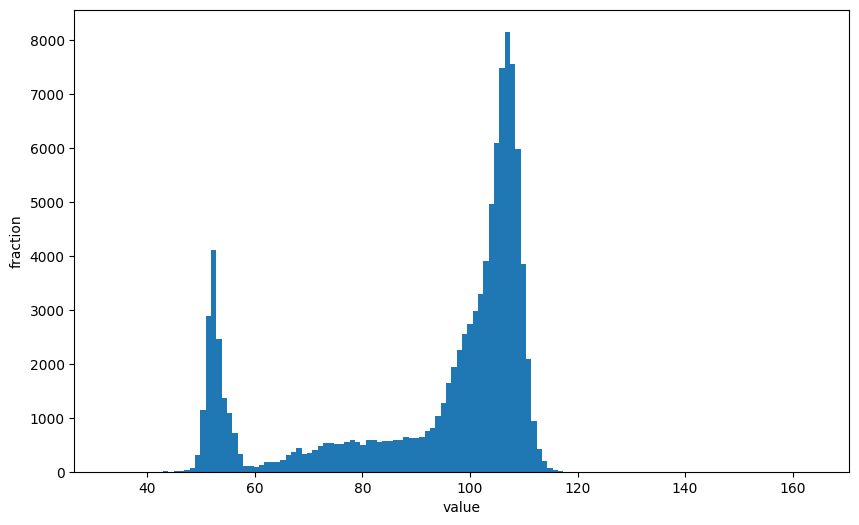

In [7]:
def create_feature_mean_byte_value(payloads):
    '''
    Feature
    Maximum byte value in payload
    '''
    
    payloads['mean-byte'] = [ np.mean(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_mean_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['mean-byte'].astype(int))

Tạo đặc trưng Độ lệch chuẩn byte trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte,mean-byte,std-byte
index,,,,,,,,
0,Yorick,0.0,LEGAL,6,0,89,104.166667,8.254628
1,audrean,0.0,LEGAL,7,0,97,105.142857,7.735421
2,Donet+Acst,0.0,LEGAL,10,1,43,94.400000,24.787900
3,Nicodemo,0.0,LEGAL,8,0,78,101.750000,10.059200
4,Waters,0.0,LEGAL,6,0,87,105.000000,10.847427


Properties of feature: std-byte
count    102146.000000
mean         10.901768
std           8.273232
min           0.000000
25%           5.000000
50%           7.000000
75%          16.000000
max          75.000000
Name: std-byte, dtype: float64


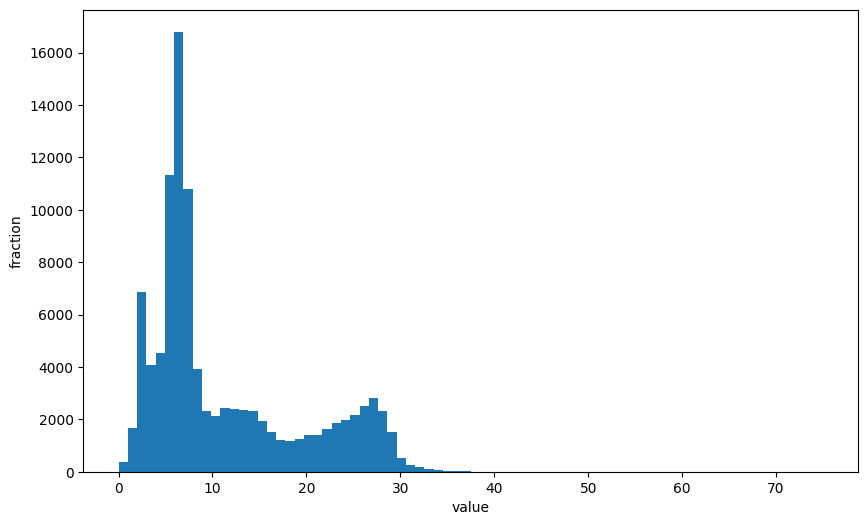

In [8]:
def create_feature_std_byte_value(payloads):

    payloads['std-byte'] = [ np.std(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_std_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['std-byte'].astype(int))

Tạo đặc trưng Số từ khóa SQL trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte,mean-byte,std-byte,sql-keywords
index,,,,,,,,,
0,Yorick,0.0,LEGAL,6,0,89,104.166667,8.254628,0
1,audrean,0.0,LEGAL,7,0,97,105.142857,7.735421,0
2,Donet+Acst,0.0,LEGAL,10,1,43,94.400000,24.787900,0
3,Nicodemo,0.0,LEGAL,8,0,78,101.750000,10.059200,0
4,Waters,0.0,LEGAL,6,0,87,105.000000,10.847427,0


Properties of feature: sql-keywords
count    102146.000000
mean          0.144724
std           0.543398
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: sql-keywords, dtype: float64


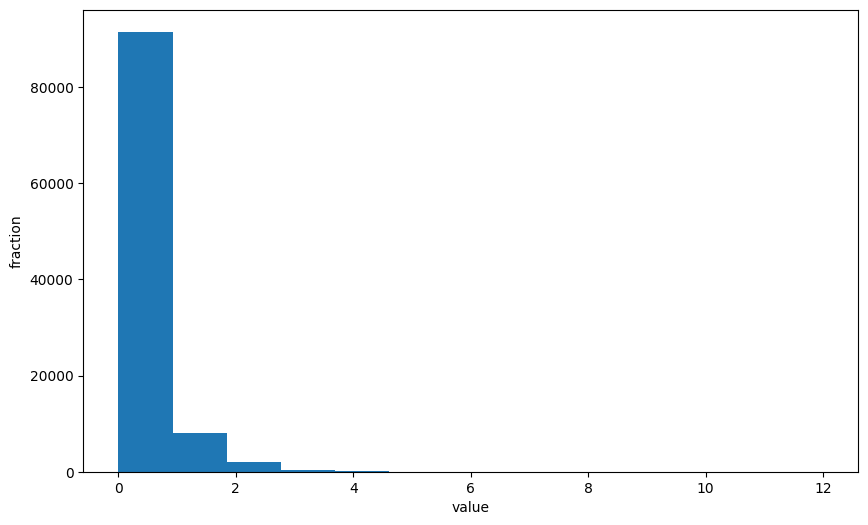

In [9]:
sql_keywords = pd.read_csv('dataset/SQLKeywords.txt', index_col=False)

def create_feature_sql_keywords(payloads):

    payloads['sql-keywords'] = [ len([1 for keyword in sql_keywords['Keyword'] if str(keyword).lower() in str(s).lower()]) for s in payloads['payload']]
    return payloads

create_feature_sql_keywords(payloads)
display(payloads.head())
plot_feature_distribution(payloads['sql-keywords'])
    

Tạo đặc trưng số từ khóa JS trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte,mean-byte,std-byte,sql-keywords,js-keywords
index,,,,,,,,,,
0,Yorick,0.0,LEGAL,6,0,89,104.166667,8.254628,0,0
1,audrean,0.0,LEGAL,7,0,97,105.142857,7.735421,0,0
2,Donet+Acst,0.0,LEGAL,10,1,43,94.400000,24.787900,0,1
3,Nicodemo,0.0,LEGAL,8,0,78,101.750000,10.059200,0,0
4,Waters,0.0,LEGAL,6,0,87,105.000000,10.847427,0,0


Properties of feature: js-keywords
count    102146.000000
mean          0.240558
std           0.520574
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: js-keywords, dtype: float64


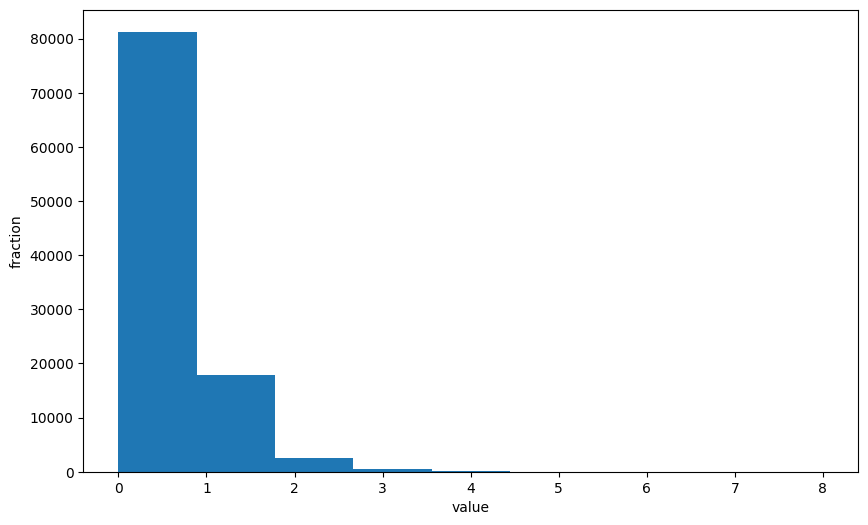

In [10]:
js_keywords = pd.read_csv('dataset/JavascriptKeywords.txt', index_col=False)

def create_feature_javascript_keywords(payloads):
    
    payloads['js-keywords'] = [len([1 for keyword in js_keywords['Keyword'] if str(keyword).lower() in str(s).lower()]) for s in payloads['payload']]
    return payloads
    

create_feature_javascript_keywords(payloads)
display(payloads.head())    
plot_feature_distribution(payloads['js-keywords'])
    
    

Sử dụng custom features tạo vector đặc trưng từ dữ liệu 

In [11]:
def create_features(payloads):
    features = create_feature_length(payloads)
    features = create_feature_punctuation_characters(features)
    features = create_feature_min_byte_value(features)
    features = create_feature_mean_byte_value(features)
    features = create_feature_std_byte_value(features)
    features = create_feature_sql_keywords(features)
    features = create_feature_javascript_keywords(features)
    del features['payload']
    return features

create_features(pd.DataFrame(payloads['payload'].copy()))

,length,punctuation,min-byte,mean-byte,std-byte,sql-keywords,js-keywords
index,,,,,,,
0,6,0,89,104.166667,8.254628,0,0
1,7,0,97,105.142857,7.735421,0,0
2,10,1,43,94.400000,24.787900,0,1
3,8,0,78,101.750000,10.059200,0,0
4,6,0,87,105.000000,10.847427,0,0
...,...,...,...,...,...,...,...
102145,25,6,32,78.880000,32.954903,1,0
102146,14,1,43,98.000000,19.752034,0,0
102147,14,0,97,104.642857,6.574921,0,0


# Step3B - Tạo đặc trưng sử dụng kĩ thuật bag-of-words
Ngoài custom feature, ta tạo thêm 4 đặc trưng sử dụng kĩ thuật bag-of-words.
Ta sẽ thực hiện kiểm tra hiệu suất độc lập với custom features tại Step 3A.  
Những đặc trưng bao gồm:
- 1-grams CountVectorizer
- 2-grams CountVectorizer
- 1-grams TfidfVectorizer
- 2-grams TfidfVectorizer


### 1-Grams features
Tạo Countvectorizer và TF-IDFvectorizer sử dụng 1-grams.  

In [12]:
def get1Grams(payload_obj):
    '''
    Ví dụ: input - payload: "<script>"
             output- ["<","s","c","r","i","p","t",">"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-1):
        ngrams.append(payload[i:i+1])
    return ngrams

tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get1Grams)
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get1Grams)

### 2-Grams features
Tạo Countvectorizer và TF-IDFvectorizer sử dụng 2-grams.

In [13]:
def get2Grams(payload_obj):
    '''
    Ví dụ: input - payload: "<script>"
             output- ["<s","sc","cr","ri","ip","pt","t>"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-2):
        ngrams.append(payload[i:i+2])
    return ngrams

tfidf_vectorizer_2grams = TfidfVectorizer(tokenizer=get2Grams)
count_vectorizer_2grams = CountVectorizer(min_df=1, tokenizer=get2Grams)